# Assignment5 of ESE5023  
---
***HUANG Pizhu***  
***12332298***

## prerequists
γ is the rate of production of CO2 by fossil-fuel burning: global.1751_2014.csv.  
Atmospheric carbon in observation: co2_annmean_mlo.csv, and observation_car_1750_2000.xlsx.  
δ is CO2 emission to the atmosphere by changes in land-use: Global_land-use_flux-1850_2005.xls


Import moduls and read and filter data.

In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib import font_manager
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

font = font_manager.FontProperties(fname='/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

## Calculate Tow Boxes Model

Observation of CO2 concentration in atmosphere.

In [2]:
# --------------------------------- read csv --------------------------------- #
df = pd.read_csv('co2_annmean_mlo.csv',comment='#')
#select year from 1986 to 2004
df = df[['year','mean']]
df = df[df['year'] >= 1986]
df = df[df['year'] <= 2004]
df.reset_index(drop=True, inplace=True)
df = df['mean']

Clean data of total carbon emissions from fossil fuel consumption

In [3]:
df2 = pd.read_csv('global.1751_2014.csv',comment='#')
df2['rate'] = df2['Total carbon emissions from fossil fuel consumption and cement production (million metric tons of C)']
-df2['Carbon emissions from cement production']
df2 = df2[['Year','rate']]
df2.drop(df2.index[0], inplace=True)

In [4]:
df2_1 = df2.iloc[235:254]
df2_1.reset_index(drop=True, inplace=True)

Definite `gamma(t)`, which is γ used in 2 boxes model.

In [5]:
df2_1['rate'] = pd.to_numeric(df2_1['rate'], errors='coerce')
gama_interp = interp1d(df2_1.index, df2_1['rate'], kind='linear', fill_value="extrapolate")
def gamma(t):
    return gama_interp(t)/2.13/1000

C:\Users\Pizhu_Huang\AppData\Local\Temp\ipykernel_18960\4220690419.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_1['rate'] = pd.to_numeric(df2_1['rate'], errors='coerce')


Slove ODEs in with and without buffer

In [6]:
# ----------------------------- definition of ODE ---------------------------- #
#k12 and k21 is constant variable
k12 = 105/740
k21 = 102/900

def pend_1(n, t):
    n1, n2 = n
    dndt = [-k12*n1+k21*n2+gamma(t), k12*n1-k21*n2]
    return dndt

# --------------------------------- slove ODE -------------------------------- #
# n1 is 347 ppm in 1986,
# n2 is 422.5 ppm in 1986
n0 = [740 / 2.13, 900 / 2.13]
# t, time, from 1987 to 2004
t = np.linspace(0, 18, num=19)

# solve ODE
sol_1 = odeint(pend_1, n0, t)
# ----------------------------- definition of ODE with buffer effect ---------------------------- #
n2_0 = 386.2

def ksi(z):
    return 3.69+0.0186*z-0.0000018*z**2

def pend_2(n, t):
    n1, n2 = n
    dndt = [-k12*n1+k21*(n2_0+ksi(n1)*(n2-n2_0))+gamma(t), k12*n1-k21*(n2_0+ksi(n1)*(n2-n2_0))]
    return dndt

# --------------------------------- slove ODE -------------------------------- #
# solve ODE
sol_2 = odeint(pend_2, n0, t)

***It looks different between my result and the one paper given under condition of buffer effect. Maybe it is caused by different method in ODEs solution.***

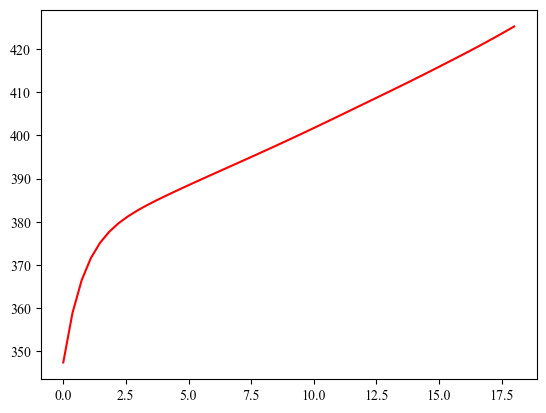

In [7]:
sol_22 = odeint(pend_2, n0, np.linspace(0, 18, num=50))
plt.plot(np.linspace(0, 18, num=50), sol_22[:, 0], 'r')

Plot the figure of the CO2 trend predicted by the two-box model with the buffer effect. The observed values and the result without and with the buffer effect are shown by dots and lines, respectively.

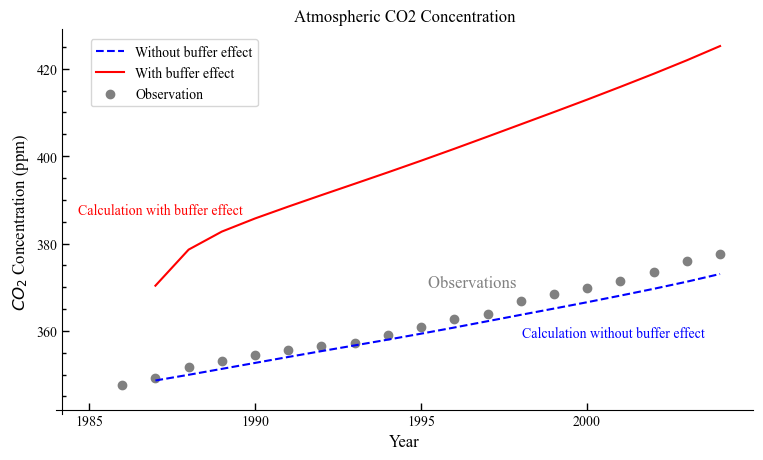

In [8]:
fig, ax = plt.subplots(figsize=(9, 5))

ax.plot(range(1987, 2005, 1), sol_1[1::, 0], 'b--')
ax.plot(range(1987, 2005, 1), sol_2[1::, 0], 'r-')
ax.scatter(range(1986, 2005, 1), df, color='gray', marker='o')

ax.set_ylabel('${CO_2}$ Concentration (ppm)', fontsize=12)
ax.set_xlabel('Year', fontsize=12)

ax.tick_params(axis='both',which="major",direction='in',length=5,width=1)
ax.tick_params(axis='both',which="minor",direction='in',length=3,width=1)
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.set_ylim(340.9, 429)
ax.set_yticks(range(360, 430, 20))
ax.set_xlim(1984, 2005)
ax.set_xticks(range(1985, 2005, 5))

ax.spines['bottom'].set_position(('data', 342))
ax.spines['left'].set_position(('data', 1984.2))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.text(0.15, 0.52, "Calculation with buffer effect", transform=plt.gca().transAxes, fontsize=10, ha='center', color='r')
ax.text(0.6, 0.33, "Observations ", transform=plt.gca().transAxes, fontsize=12, ha='center', color='gray')
ax.text(0.8, 0.2, "Calculation without buffer effect", transform=plt.gca().transAxes, fontsize=10, ha='center', color='b')

ax.set_title('Atmospheric CO2 Concentration', fontsize=12)
plt.legend(['Without buffer effect', 'With buffer effect', 'Observation'],loc=(0.05, 0.8), frameon=True, fontsize=10)
plt.show()

## Calculate Seven Boxes Model to Get the Atmospheric CO2 from 1750 to 2000.

In [9]:
df3 = pd.read_excel('landuse_car_1750_2000.xlsx')
df3 = df3['Global']/1000/2.13
# 将 "rate" 列的数据类型转换为数值型
df3 = pd.to_numeric(df3, errors='coerce')

Definite `delta(t)`, which is δ used in 7 boxes model.

In [10]:
delta_interp = interp1d(df3.index, df3, kind='linear', fill_value="extrapolate")
def delta(t):
    return delta_interp(t)

Definite `gammat(t)`, which is γ used in 7 boxes model.

In [11]:
gammat_interp = interp1d(df2.index, df2['rate'], kind='linear', fill_value="extrapolate")
def gammat(t):
    return gammat_interp(t)/2.13/1000

In [12]:
# ----------------------------- SEVEN-BOX MODEL of ODE ---------------------------- #
k12 = 60/615
k21 = 60/842
k23 = 9/842
k24 = 43/842

k32 = 52/9744
k34 = 162/9744

k43 = 205/26280
k45 = 0.2/26280

k51 = 0.2/90000000
k67 = 62/731
k71 = 62/1238

n2_0 = 395.31

def f(z,beta):
    f0 = 62 / 2.13
    p0 = 615 / 2.13
    return f0*(1+beta*np.log(z/p0))

def ksi(z):
    return 3.69+0.0186*z-0.0000018*z**2

def pend_3(n, t, beta=0.5):
    n1, n2,n3, n4, n5, n6, n7 = n
    dndt = [-k12*n1+k21*(n2_0+ksi(n1)*(n2-n2_0))+gammat(t)-f(n1,beta)+delta(t)+k51*n5+k71*n7,
            k12*n1-k21*(n2_0+ksi(n1)*(n2-n2_0))-k23*n2+k32*n3-k24*n2,
            k23*n2-k32*n3-k34*n3+k43*n4,
            k34*n3-k43*n4+k24*n2-k45*n4,
            k45*n4-k51*n5,
            f(n1,beta)-k67*n6-2*delta(t),
            k67*n6-k71*n7+delta(t)]
    return dndt
# --------------------------------- slove ODE -------------------------------- #
n0 = [615 / 2.13, 842 / 2.13, 9744 / 2.13, 26280 / 2.13, 90000000 / 2.13, 731 / 2.13, 1238 / 2.13]
t_3 = np.linspace(0, 250, num=251)
# solve ODE
sol_5 = odeint(pend_3, n0,t_3)
sol_38 = odeint(pend_3, n0, t_3, args=(0.38,))

Read data of long time Carbon dioxide

In [13]:
df4=pd.read_excel('observation_car_1750_2000.xlsx')

The CO2 trend calculated for 250 years by the seven-box model with β= 0.38 and 0.50. The observed values are shown for reference.

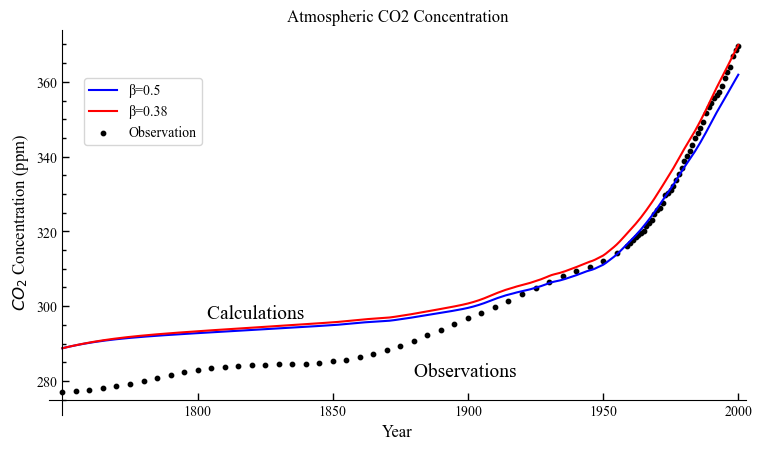

In [15]:
fig, ax = plt.subplots(figsize=(9, 5))

ax.plot(range(1750, 2001, 1), sol_5[::, 0], 'b-')
ax.plot(range(1750, 2001, 1), sol_38[::, 0], 'r-')
ax.scatter(df4['Year'], df4['ppm'], color='black', marker='o', s=10)

ax.set_ylabel('${CO_2}$ Concentration (ppm)', fontsize=12)
ax.set_xlabel('Year', fontsize=12)

ax.tick_params(axis='both',which="major",direction='in',length=5,width=1)
ax.tick_params(axis='both',which="minor",direction='in',length=3,width=1)
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.set_ylim(271, 374)
ax.set_yticks(range(280, 370, 20))
ax.set_xlim(1745, 2003)
ax.set_xticks(range(1800, 2005, 50))

ax.spines['bottom'].set_position(('data', 275))
ax.spines['left'].set_position(('data', 1750))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Text Relative to DATA
ax.text(0.3, 0.25, "Calculations ", transform=plt.gca().transAxes, fontsize=14, ha='center', color='k')
ax.text(0.6, 0.1, "Observations ", transform=plt.gca().transAxes, fontsize=14, ha='center', color='k')
ax.set_title('Atmospheric CO2 Concentration', fontsize=12)
plt.legend(['β=0.5', 'β=0.38', 'Observation'],loc = (0.05,0.7),frameon=True, fontsize=10)
plt.show()